# Predicting Employee Compensation

In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/17 09:50:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Read the Data

In [2]:
df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load("/home/ubuntu/Employee_Compensation")
df.show(5)

+---------+----+-----------------------+--------------------+---------------+--------------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group Code|  Organization Group|Department Code|          Department|Union Code|               Union|Job Family Code|          Job Family|Job Code|                 Job|Employee Identifier| Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+-----------------------+--------------------+---------------+--------------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+---

### 1.1 Display the number of rows and columns in the dataset

In [3]:
rows = df.count()
columns = len(df.columns)

print(f'Dimension of the DataFrame is: {rows, columns}')
print(f'Number of Rows: {rows}')
print(f'Number of Columns: {columns}')

Dimension of the DataFrame is: (291825, 22)
Number of Rows: 291825
Number of Columns: 22


### 1.2 Check the datatype of the variables

In [4]:
df.dtypes

[('Year Type', 'string'),
 ('Year', 'int'),
 ('Organization Group Code', 'int'),
 ('Organization Group', 'string'),
 ('Department Code', 'string'),
 ('Department', 'string'),
 ('Union Code', 'int'),
 ('Union', 'string'),
 ('Job Family Code', 'string'),
 ('Job Family', 'string'),
 ('Job Code', 'string'),
 ('Job', 'string'),
 ('Employee Identifier', 'int'),
 ('Salaries', 'double'),
 ('Overtime', 'double'),
 ('Other Salaries', 'double'),
 ('Total Salary', 'double'),
 ('Retirement', 'double'),
 ('Health/Dental', 'double'),
 ('Other Benefits', 'double'),
 ('Total Benefits', 'double'),
 ('Total Compensation', 'double')]

## 2. Convert the incorrect column type into its suitable column type. And drop the redundant features

In [5]:
# Converting the 'Year', 'Organization Group Code' and 'Union Code' columns type to string as they are not quantitative 
from pyspark.sql.functions import col

df = df.withColumn('Year', col('Year').cast('string'))
df = df.withColumn('Organization Group Code', col('Organization Group Code').cast('string'))
df = df.withColumn('Union Code', col('Union Code').cast('string'))
df.printSchema()

root
 |-- Year Type: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Organization Group Code: string (nullable = true)
 |-- Organization Group: string (nullable = true)
 |-- Department Code: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Union Code: string (nullable = true)
 |-- Union: string (nullable = true)
 |-- Job Family Code: string (nullable = true)
 |-- Job Family: string (nullable = true)
 |-- Job Code: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Employee Identifier: integer (nullable = true)
 |-- Salaries: double (nullable = true)
 |-- Overtime: double (nullable = true)
 |-- Other Salaries: double (nullable = true)
 |-- Total Salary: double (nullable = true)
 |-- Retirement: double (nullable = true)
 |-- Health/Dental: double (nullable = true)
 |-- Other Benefits: double (nullable = true)
 |-- Total Benefits: double (nullable = true)
 |-- Total Compensation: double (nullable = true)



In [6]:
# Dropping the redundant features ('Organization Group Code','Department', 'Union', 'Job Family Code', 'Job Family', 'Job Code', 'Employee Identifier') in the new dataframe df1

df1 = df.select(col('Year Type'),
                col('Year'),
                col('Organization Group'),
                col('Department Code'),
                col('Union Code'),
                col('Job'),
                col('Salaries'),
                col('Overtime'),
                col('Other Salaries'),
                col('Total Salary'),
                col('Retirement'),
                col('Health/Dental'),
                col('Other Benefits'),
                col('Total Benefits'),
                col('Total Compensation'),
                )

df1.show(2)

+---------+----+--------------------+---------------+----------+--------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|  Organization Group|Department Code|Union Code|                 Job| Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+--------------------+---------------+----------+--------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|   Fiscal|2016|   Public Protection|            DAT|       311|Attorney (Civil/C...|114473.16|     0.0|        1500.0|   115973.16|  21025.98|      13068.8|       9368.71|      43463.49|         159436.65|
| Calendar|2013|Culture & Recreation|            ART|       790|Senior Management...| 84077.11|     0.0|           0.0|    84077.11|   16587.3|     12457.73|       6931.91|

## 3. Check basic statistics and perform necessary data preprocessing (Like removing negative amount)

In [7]:
# Performing basic statistics
df1.describe().show()

+-------+---------+------------------+--------------------+---------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|Year Type|              Year|  Organization Group|Department Code|       Union Code|               Job|         Salaries|          Overtime|   Other Salaries|      Total Salary|        Retirement|    Health/Dental|    Other Benefits|    Total Benefits|Total Compensation|
+-------+---------+------------------+--------------------+---------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|   291825|            291825|              291825|         291825|           291782|            291825|           291825|            291825|        

**We can see some negative values in all the numeric columns**

In [8]:
# Removing the rows with negative amount
df2 = df1.filter((df1.Salaries >= 0 )&(df1.Overtime >= 0)&(col('Other Salaries') >= 0)&(col('Total Salary') >= 0)&(df1.Retirement >= 0)&(col('Health/Dental') >= 0)&(col('Other Benefits') >= 0)&(col('Total Benefits') >= 0)&(col('Total Compensation') >= 0))

df2.count()

290391

**We can observe that after removing the rows with columns having negative values, the row count decreased to 290391 from 291825**

## 4. Perform Missing Value Analysis

In [9]:
# Checking if the missing values are present
from pyspark.sql.functions import isnull, when, count, col

df2.select([count(when(isnull(c), c)).alias(c) for c in df2.columns]).show()

+---------+----+------------------+---------------+----------+---+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group|Department Code|Union Code|Job|Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+------------------+---------------+----------+---+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|        0|   0|                 0|              0|        43|  0|       0|       0|             0|           0|         0|            0|             0|             0|                 0|
+---------+----+------------------+---------------+----------+---+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+



*We have 43 rows of 'Union Code' column having missing values. Let us delete those rows*

In [10]:
# Dropping the missing values

df2 = df2.replace('null', None).dropna(how='any')

In [11]:
df2.count()

290348

In [12]:
df2.select([count(when(isnull(c), c)).alias(c) for c in df2.columns]).show()

+---------+----+------------------+---------------+----------+---+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group|Department Code|Union Code|Job|Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+------------------+---------------+----------+---+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|        0|   0|                 0|              0|         0|  0|       0|       0|             0|           0|         0|            0|             0|             0|                 0|
+---------+----+------------------+---------------+----------+---+--------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+



**We can observe that after removing the missing values the row count decreased to 290348 from 290391. <br>
Also we can confirm that there are no more any missing values in our dataset** 

## 5. Exploratory Data Analysis

In [22]:
# Converting our PySpark Dataframe to pandas
df3 = df2.toPandas()

In [24]:
df3.head()

,Year Type,Year,Organization Group,Department Code,Union Code,Job,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,Fiscal,2016,Public Protection,DAT,311,Attorney (Civil/Criminal),114473.16,0.0,1500.00,115973.16,21025.98,13068.80,9368.71,43463.49,159436.65
1,Calendar,2013,Culture & Recreation,ART,790,Senior Management Assistant,84077.11,0.0,0.00,84077.11,16587.30,12457.73,6931.91,35976.94,120054.05
2,Calendar,2015,Community Health,DPH,535,Eligibility Worker,9980.17,0.0,798.43,10778.60,0.00,2254.93,835.11,3090.04,13868.64
3,Fiscal,2015,Community Health,DPH,250,Dental Aide,2873.41,0.0,0.00,2873.41,0.00,622.63,222.46,845.09,3718.50
4,Fiscal,2014,Culture & Recreation,REC,790,Recreation Leader,6701.85,0.0,176.70,6878.55,0.00,2711.66,538.43,3250.09,10128.64


In [25]:
df3.duplicated().sum()

3335

In [26]:
df3.drop_duplicates(inplace = True)
df3.duplicated().sum()

0

### 5.1. Find top compensating organizations. Display using bar plot

In [52]:
# Displaying the Top Compensating Organizations
df_top_comp_org = df3.groupby(['Organization Group'])['Total Compensation'].max().sort_values(ascending=False)
df_top_comp_org.head(10)

Organization Group
General Administration & Finance            653498.15
Public Protection                           510574.44
Public Works, Transportation & Commerce     430872.68
Community Health                            422799.94
Human Welfare & Neighborhood Development    372586.30
Culture & Recreation                        318713.18
General City Responsibilities               137930.88
Name: Total Compensation, dtype: float64

In [64]:
import pandas as pd
dfx  = pd.DataFrame(data = df_top_comp_org)

In [65]:
dfx.head()

,Total Compensation
Organization Group,
General Administration & Finance,653498.15
Public Protection,510574.44
"Public Works, Transportation & Commerce",430872.68
Community Health,422799.94
Human Welfare & Neighborhood Development,372586.30


In [68]:
dfx.reset_index(level=0, inplace=True)
dfx

,Organization Group,Total Compensation
0,General Administration & Finance,653498.15
1,Public Protection,510574.44
2,"Public Works, Transportation & Commerce",430872.68
3,Community Health,422799.94
4,Human Welfare & Neighborhood Development,372586.30
5,Culture & Recreation,318713.18
6,General City Responsibilities,137930.88


Text(0, 0.5, 'Maximum Compensation')

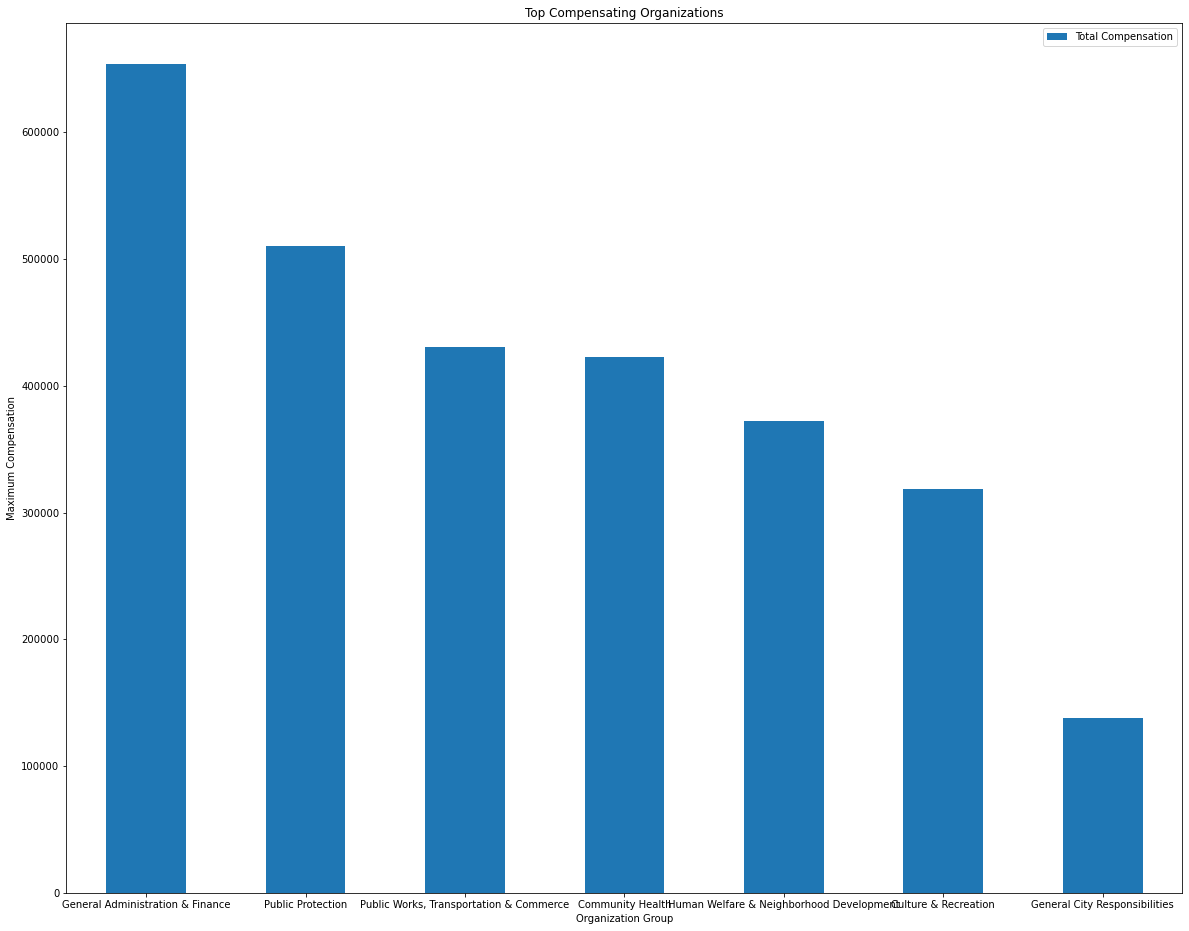

In [79]:
# Displaying bar plot of the Top compensating Organizations in Descending order of the maximum compensation
import matplotlib.pyplot as plt
dfx.plot.bar(x='Organization Group', y='Total Compensation', rot =0, figsize=(20,16))
plt.title("Top Compensating Organizations")
plt.xlabel('Organization Group')
plt.ylabel('Maximum Compensation')

### 5.2. Find top Compensating Jobs. Display using bar plot

In [85]:
# Displaying the Top 10 Compensating Jobs
df_top_comp_job = df3.groupby(['Job'])['Total Compensation'].max().sort_values(ascending=False)[:10]
df_top_comp_job.head(10)

Job
Chief Investment Officer          653498.15
Deputy Chief 3                    510574.44
Asst Med Examiner                 497505.00
Chief Of Police                   466798.21
Dept Head V                       433302.72
Chief, Fire Department            426006.85
Battlion Chief, Fire Suppressi    425605.01
Adm, SFGH Medical Center          422799.94
Executive Contract Employee       422019.78
Senior Physician Specialist       418013.58
Name: Total Compensation, dtype: float64

In [86]:
dfy  = pd.DataFrame(data = df_top_comp_job)
dfy.reset_index(level=0, inplace=True)
dfy

,Job,Total Compensation
0,Chief Investment Officer,653498.15
1,Deputy Chief 3,510574.44
2,Asst Med Examiner,497505.00
3,Chief Of Police,466798.21
4,Dept Head V,433302.72
5,"Chief, Fire Department",426006.85
6,"Battlion Chief, Fire Suppressi",425605.01
7,"Adm, SFGH Medical Center",422799.94
8,Executive Contract Employee,422019.78
9,Senior Physician Specialist,418013.58


Text(0, 0.5, 'Maximum Compensation')

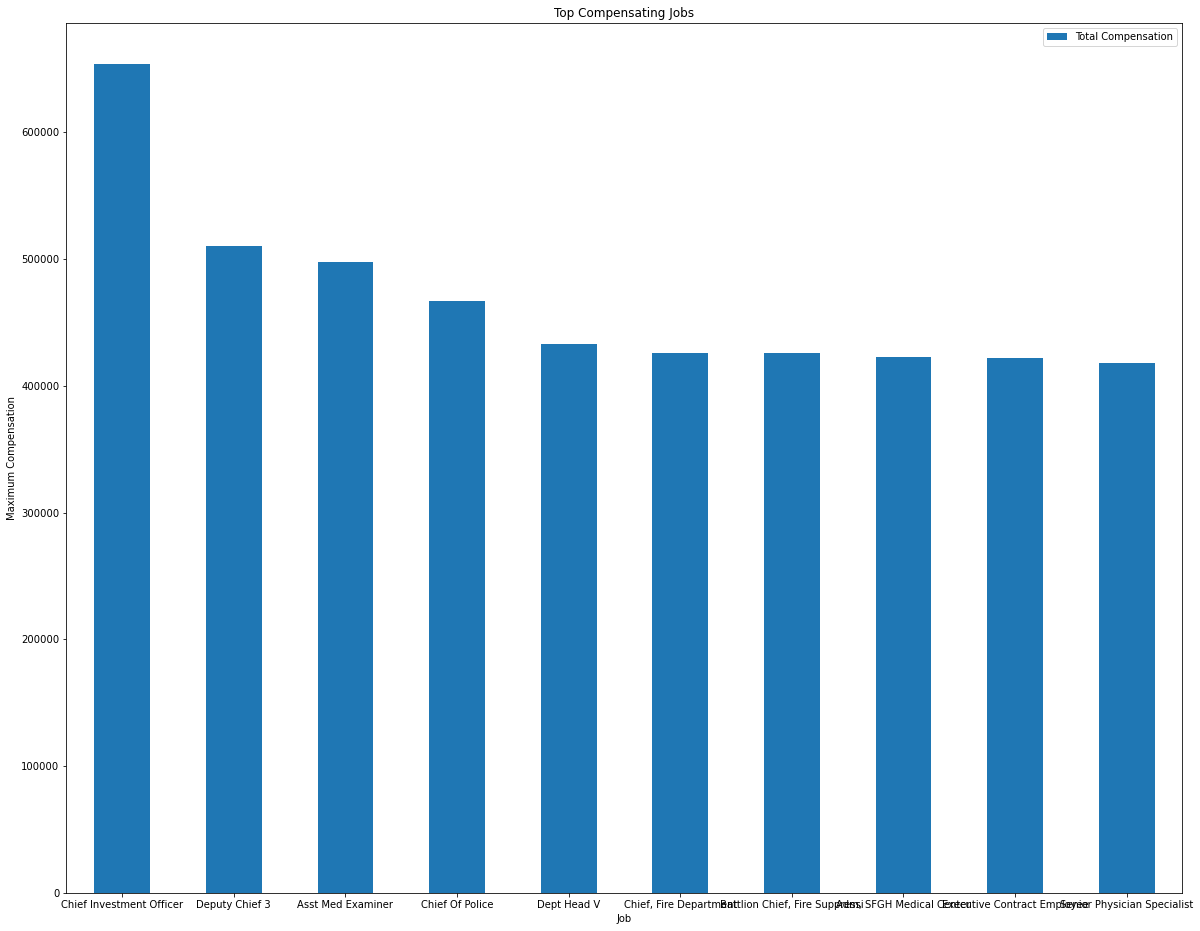

In [87]:
# Displaying the bar plot of the Top 10 compensating Jobs in the Descending order of the maximum compensation
dfy.plot.bar(x='Job', y='Total Compensation', rot =0, figsize=(20,16))
plt.title("Top Compensating Jobs")
plt.xlabel('Job')
plt.ylabel('Maximum Compensation')

### 5.3. Check Correlation of Target Variable with Other Independent Variables. Plot Heatmap

In [45]:
corr = df3.corr(numeric_only = True)
corr

,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Salaries,1.000000,0.267833,0.327971,0.959857,0.952338,0.768929,0.691553,0.936840,0.972092
Overtime,0.267833,1.000000,0.351720,0.494999,0.310655,0.310054,0.056256,0.284406,0.452206
Other Salaries,0.327971,0.351720,1.000000,0.502704,0.344915,0.211976,0.036342,0.271459,0.454952
Total Salary,0.959857,0.494999,0.502704,1.000000,0.930824,0.754475,0.608109,0.901148,0.994247
Retirement,0.952338,0.310655,0.344915,0.930824,1.000000,0.790465,0.665255,0.965000,0.956648
Health/Dental,0.768929,0.310054,0.211976,0.754475,0.790465,1.000000,0.590644,0.886375,0.801153
Other Benefits,0.691553,0.056256,0.036342,0.608109,0.665255,0.590644,1.000000,0.787136,0.663699
Total Benefits,0.936840,0.284406,0.271459,0.901148,0.965000,0.886375,0.787136,1.000000,0.942399
Total Compensation,0.972092,0.452206,0.454952,0.994247,0.956648,0.801153,0.663699,0.942399,1.000000


<AxesSubplot:>

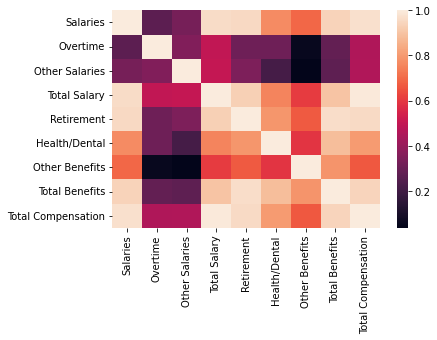

In [46]:
import seaborn as sns
sns.heatmap(corr)

## 6. Perform necessary data pre-processing and divide the data into train and test set

### 6.1 Categorise the attributes into its type (Use one hot encoding wherever required)

In [98]:
cols = df2.columns

In [96]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder,   StringIndexer, VectorAssembler

categoricalColumns = ['Year Type', 'Year', 'Organization Group', 'Department Code', 'Union Code', 'Job']

stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
    
numericCols =  ['Salaries', 'Overtime', 'Other Salaries', 'Total Salary', 'Retirement', 'Health/Dental', 'Other Benefits', 'Total Benefits', 'Total Compensation']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [99]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df2)
df_encoded = pipelineModel.transform(df2)
selectedCols = ['features'] + cols
df_encoded = df_encoded.select(selectedCols)

In [101]:
df_encoded.show(2)

23/12/17 12:26:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+---------+----+--------------------+---------------+----------+--------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|            features|Year Type|Year|  Organization Group|Department Code|Union Code|                 Job| Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+--------------------+---------+----+--------------------+---------------+----------+--------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|(1275,[0,6,29,78,...|   Fiscal|2016|   Public Protection|            DAT|       311|Attorney (Civil/C...|114473.16|     0.0|        150

### 6.2 Split the data into train and test set

In [104]:
train, test = df_encoded.randomSplit([0.7, 0.3], seed = 42)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 203288 training examples and 87060 test examples.


## 7. Fit Linear Regression model on the data and check its performance

In [109]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol = 'Total Compensation', featuresCol = 'features')
lr_model = lr.fit(train)
result = lr_model.evaluate(test)
result.rootMeanSquaredError

23/12/17 12:44:17 WARN Instrumentation: [d4b96a37] regParam is zero, which might cause numerical instability and overfitting.


23/12/17 12:44:23 WARN Instrumentation: [d4b96a37] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


3.64361592956886

In [111]:
result.meanSquaredError

13.275937042207948

In [112]:
result.meanAbsoluteError

1.4637432533317685

In [110]:
result.r2

0.9999999970936833

**We can see that the performance of our model is very high (99.9999... %)!**

## 8. Fit Decision Tree Regression model on the data and check its performance

In [114]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Total Compensation')
dt_model = dt.fit(train)

23/12/17 12:55:03 WARN MemoryStore: Not enough space to cache rdd_410_1 in memory! (computed 178.4 MiB so far)
23/12/17 12:55:03 WARN BlockManager: Persisting block rdd_410_1 to disk instead.
23/12/17 12:55:04 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 115.0 MiB so far)
23/12/17 12:55:04 WARN BlockManager: Persisting block rdd_410_0 to disk instead.
23/12/17 12:55:07 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 22.1 MiB so far)
23/12/17 12:55:07 WARN MemoryStore: Not enough space to cache rdd_410_1 in memory! (computed 410.3 MiB so far)


23/12/17 12:55:10 WARN MemoryStore: Not enough space to cache rdd_410_1 in memory! (computed 178.9 MiB so far)
23/12/17 12:55:10 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 178.9 MiB so far)


23/12/17 12:55:12 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 178.9 MiB so far)
23/12/17 12:55:12 WARN MemoryStore: Not enough space to cache rdd_410_1 in memory! (computed 178.9 MiB so far)


23/12/17 12:55:15 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 178.9 MiB so far)
23/12/17 12:55:15 WARN MemoryStore: Not enough space to cache rdd_410_1 in memory! (computed 178.9 MiB so far)


23/12/17 12:55:17 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 178.9 MiB so far)
23/12/17 12:55:17 WARN MemoryStore: Not enough space to cache rdd_410_1 in memory! (computed 178.9 MiB so far)


In [147]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

predictions = dt_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="Total Compensation", predictionCol='prediction', metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(accuracy)

0.0


## 9. Model Persistence

**_Saving the model_**

In [149]:
lr_model.write().overwrite().save("/home/ubuntu/models/lrmodel")

**_Loading the model_**

In [162]:
from pyspark.ml.regression import LinearRegressionModel

linearmodel = LinearRegressionModel.load("/home/ubuntu/models/lrmodel")

prediction = linearmodel.transform(test)
prediction.select('Organization Group', 'Job', 'Total Compensation', 'prediction').show(5)

+--------------------+---------+------------------+------------------+
|  Organization Group|      Job|Total Compensation|        prediction|
+--------------------+---------+------------------+------------------+
|Public Works, Tra...|Custodian|          45261.38| 45258.92270826888|
|Public Works, Tra...|Custodian|          86964.02| 86961.91816155626|
|Public Works, Tra...|Custodian|          87426.93| 87424.94772531638|
|Public Works, Tra...|Custodian|          94823.46| 94821.33415519928|
|Public Works, Tra...|Custodian|          104331.3|104329.17975430728|
+--------------------+---------+------------------+------------------+
only showing top 5 rows



**Hence, we are able to persist the Model, i.e., we are able to save and load our model!!! <br>
Pretty awesome... :)**